In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ignite.metrics import Accuracy, Precision, Recall 
import yfinance as yf
import pandas as pd

In [49]:
signal = torch.tensor(yf.download(tickers='BTC-USD', period='5d', interval = '2m')['High'].values, dtype=torch.float32)

[*********************100%***********************]  1 of 1 completed


In [50]:
def standardize(array):
    mean = array.mean()
    std = array.std()
    standardized = (array - mean) / std
    return standardized, (mean, std)

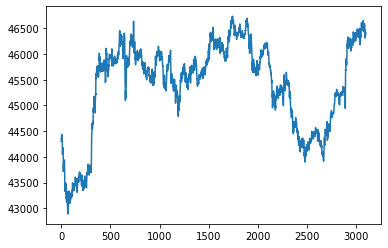

In [51]:
plt.plot(signal)

In [52]:
def chunkize(series, chunk_size):
    n_chunks = len(series) - chunk_size
    chunked = []
    for i in range(n_chunks):
        chunk, _ = standardize(series[i: i+chunk_size])
        data = chunk[:-1]
        target = chunk[-1]
        chunked.append([data, target])
    
    return chunked
        

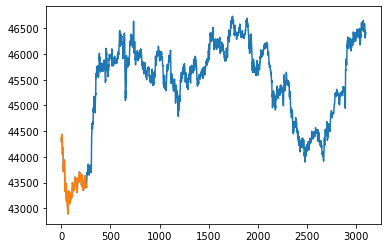

In [53]:
chunksize = 256
chunked = chunkize(signal, chunksize)

plt.plot(signal)
plt.plot(signal[:chunksize])

In [54]:
class Signal(Dataset):
    
    def __init__(self, dataset, phase=None):
        
        if phase == 'train':
            start = 0
            end = int(len(dataset)*.5)
        if phase == 'val':
            start = int(len(dataset)*.5)
            end = int(len(dataset)*.75)
        if phase == 'test':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)
    
        self.dataset = dataset[start:end]


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.dataset[idx][0].unsqueeze(1)
        target = self.dataset[idx][1]
            
        return data, target

In [55]:
train_set = Signal(chunked, 'train')
val_set = Signal(chunked, 'val')
test_set = Signal(chunked, 'test')

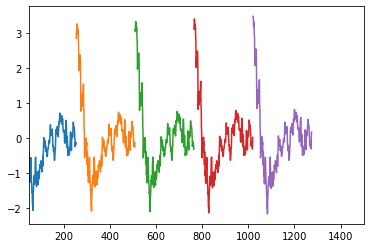

In [56]:
for idx, sample in enumerate(train_set.dataset):
    if idx == 5:
        break
    plt.plot(torch.arange(idx*len(sample[0]), idx*len(sample[0])+len(sample[0])), sample[0])
    plt.xlim(50, 1500)

In [57]:
len(train_set)

2840

In [58]:
# hyperparams
batch_size = 128
learning_rate = 0.1
num_epochs = 30

In [59]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [60]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=.2)

        self.fc1 = nn.Linear(hidden_size, 1)
    
    def forward(self,x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [61]:
model = LSTM1(1, 50, 4)

In [62]:
if torch.cuda.is_available:
    device = 'cuda'
else:
    device = 'cpu'

model.to(device)

LSTM1(
  (lstm): LSTM(1, 50, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=50, out_features=1, bias=True)
)

In [63]:
model(torch.rand(2, 4, 1).to(device))

tensor([[0.1304],
        [0.1363]], device='cuda:0', grad_fn=<AddmmBackward>)

In [64]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.MSELoss()

In [65]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []

for epoch in range(num_epochs):


    model.train()
    epoch_progress = tqdm(total=len(train_loader), desc=f'Epoch {epoch}', leave=False)
    for data, target in train_loader:

        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = torch.squeeze(model(data))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
    epoch_progress.close()
    
    model.eval()
    val_progress = tqdm(total=len(val_loader), desc=f'Epoch {epoch}. Validating...', leave=False)
    val_losses = []
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = torch.squeeze(model(data))
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
        val_progress.update()
    val_progress.close()    
        
    mean_val_loss = torch.mean(torch.tensor(val_losses))
    epoch_losses.append(mean_val_loss)

    if mean_val_loss == min(epoch_losses):
        torch.save(model, 'min_loss.pt')
        
    scheduler.step(mean_val_loss)
    
    print(f"Val loss {epoch}: {epoch_losses[-1]}")

    total_progress.update()

total_progress.close()

Val loss 0: 2.0663092136383057


Val loss 1: 2.0084099769592285


Val loss 2: 0.6545385122299194


Val loss 3: 0.3897286653518677


Val loss 4: 0.4138711094856262


Val loss 5: 0.5333243608474731


Val loss 6: 0.26149052381515503


Val loss 7: 0.22579824924468994


Val loss 8: 0.26149845123291016


Val loss 9: 0.400073766708374


Val loss 10: 0.19587954878807068


Val loss 11: 0.18285809457302094


Val loss 12: 0.2317287176847458


Val loss 13: 0.1580561101436615


Val loss 14: 0.24284660816192627


Val loss 15: 0.13827267289161682


Val loss 16: 0.24112223088741302


Val loss 17: 0.1336500197649002


Val loss 18: 0.12125565856695175


Val loss 19: 0.20245036482810974


Val loss 20: 0.1261194944381714


Val loss 21: 0.11727793514728546


Val loss 22: 0.15987800061702728


Val loss 23: 0.17098207771778107


Val loss 24: 0.11139379441738129


Val loss 25: 0.1313731074333191


Val loss 26: 0.1174439787864685


Val loss 27: 0.11837023496627808


Val loss 28: 0.08943770080804825


Val loss 29: 0.13245467841625214



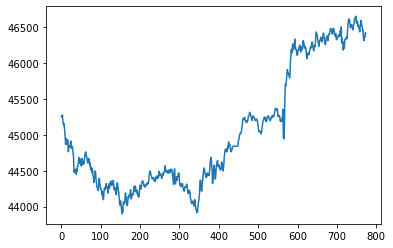

In [66]:
test_signal = signal[int(len(signal)*.75):]
plt.plot(test_signal)

In [67]:
model = torch.load('min_loss.pt')
model.to(device)

LSTM1(
  (lstm): LSTM(1, 50, num_layers=4, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=50, out_features=1, bias=True)
)

In [68]:
model.eval()
initial_data = test_signal[:chunksize-1].tolist()


def prepare(data):
    return data.reshape(1, -1, 1).to(device)

preds = []

num_predictions = 200
progress = tqdm(total=num_predictions, desc='Progress')
for i in range(num_predictions):
    standardized, (mean, std) = standardize(torch.tensor(initial_data))
    pred = model(prepare(standardized)).squeeze().tolist() * std + mean
    preds.append(pred)
    # initial_data.append(pred)
    # initial_data.pop(0)
    initial_data = test_signal[i:chunksize-1 + i].tolist()
    progress.update()
    
progress.close()

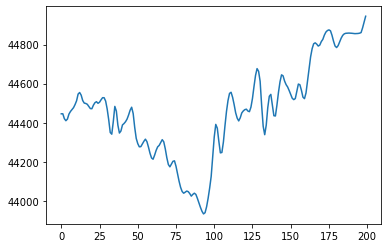

In [69]:
plt.plot(preds)

(0.0, 1500.0)

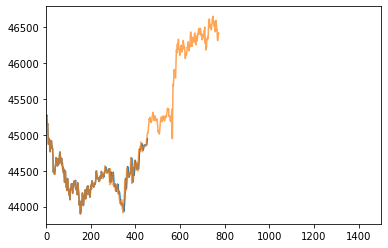

In [70]:
a = test_signal[:chunksize-1].tolist()
a.extend(preds)
plt.plot(a)
b = test_signal[:1000].tolist()
plt.plot(b, alpha=0.7)
plt.xlim(0, 1500)

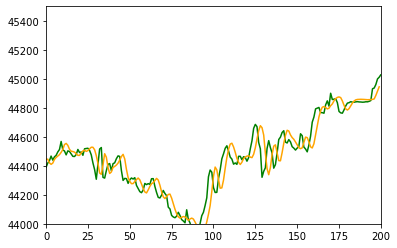

In [107]:
plt.plot(test_signal[chunksize-1:], c='g')
plt.plot(preds, c='orange')
#3plt.xlim(256)
plt.xlim(0, 200)
plt.ylim(44000, 45500)
plt.show()